In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re

### Meeting notes

Outcomes of interest

- medication use
- time to normal diet
- harms

Can use study-specific random effect to account for differneces in baseline dosages among study sites.


Post-op nausea, vomiting, dehydration (everything but bleeding)
- assume "unspecified" is NOT bleeding
Post-op bleeding

Meds/pain management

Antibiotics

Re-op is only for bleeding.

## Data import and cleaning

Import outcome data and rename columns

In [2]:
data_file = 'data/Tonsillectomy_Master_Outcome_data_Comparative_studies_04112016.xlsx'

raw_data = (pd.read_excel(data_file, 
              sheetname='All_outcomes_KQ3-6', 
              na_values=['null', 'ND'])
            .drop(['Comments', 'Other stats \nName','Other Stats','Results'], 
                  axis=1)
            .rename(columns={'OUTC_Main_\nCATG':'outcome_cat',
                            "Outc_SUB_\nCATG":'outcome_subcat',
                            'Outcome\nN': 'N',
                            'Outcome  \n%': 'outcome_pct',
                            "Outcome\n Mean": 'outcome_mean',
                            "Outcome \nSD": 'outcome_sd',
                            "Outcome \n Median": 'outcome_med',
                            "Outcome \n 95% L": 'outcome_lo_95',
                            "Outcome \n 95% H": 'outcome_hi_95'}))
raw_data.shape

(858, 33)

In [3]:
raw_data.REFID.unique()

array([2428, '2770_2821_3271', 2607, 3119, 3163, 1800, 2365, 2503,
       '2071_362', 953, 7109, 6809, 914, 2376, 2520, 2608, 2669, 2870,
       2889, 2891, 2935, 2981, 3172, 3351, 3508, 3592, 3651, 3659, 3679,
       3745, 3747, 1649, 2046, 2072, '2108_1451', 2240, 2313, 2358, 1414,
       1691, 2221, 2570, 3253, 354, 535, 1222, 1235, 1060, 3961, 6261,
       6317, 6895, 6917, 6327, '1843_1437', 1095, 7401, 1372, 1505, 2290,
       3501, 7142, 7211, 192, 253, 382, 470, 493, 1039, 1085, 1108, 1898,
       2213, 2550, 3326, 3857, 3865, 4033, 2629, 2853, 3031, 3086, 3155,
       3213, 3287, 3498, 3558, 6295, 6432, 6452, 6529, 6728, 7078, 7170,
       109, 290, 1171, 7129, 1170, 5322, 3243, 6210, 3002, 3149, 2949,
       6313, 6899, 2955, 3741, 2943, 2936, 2297, 2198, 1501, 1315, 1183,
       1991, 6217, 6586, 7241, 1043, 4280], dtype=object)

Import sample size information for each study

In [4]:
baseline_data = pd.read_excel(data_file, 
              sheetname='BASIC_Charact', na_values=['null', 'ND', 'NA'])

Attempting to aggregate groups

In [24]:
raw_data['Intervention_Category'] = raw_data.Intervention_Category.str.lower().str.strip()
raw_data['Outcome_specify'] = raw_data.Outcome_specify.str.lower().str.strip()
clean_data = raw_data.replace({'Intervention_Category':{'saline':'control',
                        'control (no rx)':'control',
                        'control (no dexamethasone)':'control',
                        'no antibiotics':'control',
                        'no steroid':'control',
                        'placebo':'control'}})

Merge data tables

In [25]:
data_merged = clean_data.merge(baseline_data, on='REFID')

In [26]:
data_merged.columns

Index(['Citation', 'REFID', 'Child Paper', 'Number of \nArms', 'Rx Grouping',
       'Group_Desc', 'Intervention_Category', 'Dose', 'Route', 'Rx_Durn',
       'Last Assesment tmpt for the study', 'Followup duration category',
       'outcome_cat', 'outcome_subcat', 'Outcome_specify',
       'Presentation \nlocation', 'Outc_Unit', 'Outc_Tool',
       'Outcome timepoint (when was this outcome measured, e.g., in PACU, 12 months post-op, immediately post-op--would need a row for each outcome at each timepoint of interest)',
       'Outcome sample size', 'Outcome\ncount', 'outcome_pct', 'outcome_mean',
       'outcome_sd', 'Outcome \n SE', 'outcome_med', 'Outcome\n _Q1',
       'Outcome \n_Q3', 'Outcome\n  Min', 'Outcome \n Max', 'outcome_lo_95',
       'outcome_hi_95', 'Comments 2_x', 'Child_ID', 'Population_Catg',
       'Diagnostic Method', 'Population\n specify', 'Trial name',
       'Study Design', 'Rx setting\n', 'Intervention TMPT', 'Rx Durn',
       'Last FUP \nTMPT', 'KQ', 'ArmsN',

In [27]:
data_merged.outcome_cat.value_counts()

Harms                        435
Pain management              159
Return to normal diet         90
Return to normal activity     52
Emesis Management             40
Throat infection              12
Health                        10
Tonsillar regrowth             8
Sleep                          8
Return to School               4
Cognitive                      2
QOL                            2
Name: outcome_cat, dtype: int64

Filter readmission data by looking for outcomes with "admission" or "visit" in the name

In [122]:
readmission_outcomes = data_merged[data_merged.outcome_subcat.str.contains(r'admission|visit')]

Extract top-3 interventions

In [28]:
interventions_of_interest = data_merged.Intervention_Category.value_counts()[:3].index.values

In [29]:
data_merged.outcome_cat.value_counts()

Harms                        435
Pain management              159
Return to normal diet         90
Return to normal activity     52
Emesis Management             40
Throat infection              12
Health                        10
Tonsillar regrowth             8
Sleep                          8
Return to School               4
Cognitive                      2
QOL                            2
Name: outcome_cat, dtype: int64

In [30]:
data_merged.outcome_subcat.value_counts()

Harms: Post-op bleeding                194
Pain management                        158
Time to Return to normal diet           90
Harms-Re-operation for bleeding         77
Time to Return to normal activity       54
Harms- readmission for bleeding         42
Emesis Management                       40
Harms- readmission for dehydration      38
Harms-other                             24
Harms- readmission for PONV             18
Harms-Death-30 day                      12
Throat infection-number                 10
Harms- readmission for post-op pain      9
Health-Growth                            8
Tonsillar regrowth                       8
Harms-readmission-unspecified            4
Sleep-Quality-OSA-18                     4
Harms- ER visit-Unspecified              4
Harms- ER visit for post-op pain         3
Harms- ER visit for bleeding             2
Harms-Velopharyngeal insufficiency       2
Throat infection-# strep infections      2
Health-Enuresis                          2
Harms - Hos

### Time to return to normal diet

In [31]:
ttr_data = data_merged[data_merged.outcome_cat=='Return to normal diet']
ttr_data.shape

(90, 63)

In [32]:
ttr_data.Intervention_Category.value_counts()

total electrocautery                                      25
total cold                                                16
total coblation                                           14
partial coblation                                          8
control                                                    5
perioperative steroid                                      5
partial microdebrider                                      2
perioperative nsaid                                        2
total laser                                                2
total harmonic scalpel                                     2
perioperative anesthetic                                   2
total microdebrider                                        1
postoperative antibiotic with beta lactamase inhibitor     1
total thermal welding                                      1
partial electrocautery                                     1
postoperative steroid                                      1
partial laser           

There do not appear to be sufficient data to analyze time to return to normal diet for pharmacologic interventions.

### Pain Management

In [33]:
pm_data = data_merged[(data_merged.outcome_cat=='Pain management') 
                      & (data_merged.Intervention_Category.str.startswith('perioperative'))]
pm_data.shape

(109, 63)

In [34]:
pm_data.Intervention_Category.value_counts()

perioperative steroid             49
perioperative antiemetic          24
perioperative nsaid               20
perioperative local anesthetic     5
perioperative anesthetic           5
perioperative opiate analgesic     3
perioperative opioid analgesic     1
perioperative anti-convulsant      1
perioperative analgesic            1
Name: Intervention_Category, dtype: int64

In [35]:
pm_data.Outcome_specify.value_counts()

patients needing analgesics for mild pain (acetaminophen)         6
patients needing analgesics for severe pain (pentazocine)         6
number of rescue analgesia (morphine) needed, 5-24 hrs            5
number of rescue analgesia (morphine) needed, 51 mins-5 hrs       5
number of rescue analgesia (morphine) needed, 0-50 minutes        5
patients needing paracetamol for pain                             4
patients needing morphine in pacu                                 3
patients needing ibuprofen                                        3
analgesics for mild pain (acetaminophen)                          3
analgesics for severe pain (pentazocine)                          3
number of analgesic interventions (paracetamol) - day 3           2
doses of pethidine for post-op pain (0.5 hrs post-op)             2
doses of pethidine for post-op pain (12 hrs post-op)              2
number of analgesic interventions (paracetamol) - day 2           2
patients needing pentazocine for severe pain    

## Harms

In [106]:
harms_data = data_merged[(data_merged.outcome_cat=='Harms') 
                      & (data_merged.Intervention_Category.str.startswith('perioperative'))
                      & (~data_merged.Group_Desc.str.contains('tonsillectomy'))]
harms_data.shape

(58, 63)

Just looking at perioperative steroid, antiemetic, NSAID

In [107]:
harms_data.Intervention_Category.value_counts()

perioperative steroid             31
perioperative antiemetic          11
perioperative nsaid               10
perioperative anesthetic           2
perioperative opiate analgesic     1
perioperative opioid analgesic     1
perioperative local anesthetic     1
perioperative analgesic            1
Name: Intervention_Category, dtype: int64

In [108]:
interventions_list = harms_data.Intervention_Category.value_counts().index[:3].values
interventions_list

array(['perioperative steroid', 'perioperative antiemetic',
       'perioperative nsaid'], dtype=object)

Restricting outcomes to serious harms, e.g. bleeding or death

In [118]:
outcomes_list = ['readmission for bleeding',
       're-operation for bleeding', 'post-op hemorrhage',
       'post-op tonsillar fossa hemorrhage',
       're-operation for post-op hemorrhage', 'post-op bleeding',
       'primary post-op bleeding', 'death', 'serious adverse events',
       'reoperation for post-op bleeding', 'secondary bleeding']
excluded_outcomes = ['adverse events', 'readmission for ponv', 'side effects reported', 
                     'readmission for post-op pain', 'readmission for adverse events', 'er visit -  unspecified']

pharm_harms = harms_data[harms_data.Intervention_Category.isin(interventions_list)
                        & harms_data.Outcome_specify.isin(outcomes_list)].copy()
pharm_harms.Outcome_specify.value_counts()

serious adverse events                 11
post-op bleeding                       10
re-operation for bleeding               9
readmission for bleeding                4
secondary bleeding                      2
re-operation for post-op hemorrhage     1
post-op tonsillar fossa hemorrhage      1
post-op hemorrhage                      1
death                                   1
primary post-op bleeding                1
reoperation for post-op bleeding        1
Name: Outcome_specify, dtype: int64

In [136]:
STEROID, ANTIEMETIC, NSAID = 0, 1, 2

pharm_harms['intervention'] = pharm_harms.Intervention_Category.replace({'perioperative steroid':STEROID, 
                                                                         'perioperative antiemetic':ANTIEMETIC,
                                                                         'perioperative nsaid':NSAID})



Convert to common dosage

In [137]:
dose_clean = (pharm_harms.Dose
         .str.replace('kg-1', 'kg')
         .str.replace('mg/kg', ' mg')
         .str.replace('µg/kg', ' µg')
         .str.replace('ug/kg', 'µg')
         .str.split())

In [138]:
pharm_harms['dose_mg'] = dose_clean.apply(lambda x: x[0] if x[1]=='mg' else (float(x[0]))/1000).astype(float)

Re-map pharmacological intervention to clean up names.

In [139]:
pharm_harms['drug'] = pharm_harms.Group_Desc.replace({'Dexamethasone':'dexamethasone',
                                                'Dexamethasone, 0.05 mg/kg':'dexamethasone',
                                                'Dexamethasone, 0.15 mg/kg':'dexamethasone',
                                                'Dexamethasone, 0.2 mg/kg':'dexamethasone',
                                                'Dexamethasone, 0.5 mg/kg':'dexamethasone',
                                                'Dexamethasone, 0.7 mg/kg':'dexamethasone',
                                                'Diclofenac':'diclofenac',
                                                'Granisetron':'granisetron',
                                                'Ketorolac, perioperative':'ketorolac',
                                                'Ketoroloc':'ketorolac',
                                                'Methylprednisolone':'methylprednisolone',
                                                'Ramosetron':'ramosetron',
                                                'dexamethasone sodium phosphate':'dexamethasone',
                                                'intravenous dexamethasone (DEX-IV)':'dexamethasone',
                                                'local infiltration dexamethasone (DEX-INF)':'dexamethasone',
                                                'lornoxicam (8 mg) unilateral ':'lornoxicam',
                                                'ramosetron 12µg/kg':'ramosetron',
                                                'ramosetron 3µg/kg':'ramosetron',
                                                'ramosetron 6µg/kg':'ramosetron'})

In [199]:
outcome_cols = pharm_harms.columns[pharm_harms.columns.str.startswith('Outcome')]

In [145]:
analysis_cols = ['REFID', 'Outcome sample size', 'Outcome\ncount', 'drug', 'dose_mg', 'intervention']
pharm_analysis_subset = pharm_harms[analysis_cols]

REFID, N, events, drug, dose, intervention = pharm_analysis_subset.values.T

In [150]:
assert pharm_analysis_subset.notnull().sum().all()

In [148]:
pharm_analysis_subset.head()

,REFID,Outcome sample size,Outcome count,drug,dose_mg,intervention
432,253,34.0,0,lornoxicam,8.0,2
435,253,34.0,0,lornoxicam,8.0,2
438,382,20.0,0,dexamethasone,1.0,0
470,493,73.0,2,ibuprofen,10.0,2
472,493,73.0,1,ibuprofen,10.0,2


In [165]:
refid_list = list(set(REFID))
study_id = pharm_analysis_subset.REFID.apply(lambda i: refid_list.index(i)).values
n_studies = len(refid_list)

In [214]:
from pymc3 import (NUTS, sample, Model, Deterministic, find_MAP,
                  Binomial, Normal, HalfCauchy, advi,
                  traceplot, summary, forestplot)
import theano.tensor as tt

In [222]:
def tinvlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

with Model() as pharm_model:
    
    # Mean for each intervention type
    θ = Normal('θ', 0, sd=5, shape=3, testval=np.ones(3)*-2)
    
    # Study random effect
    σ = HalfCauchy('σ', 5, testval=1)
    ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies, testval=np.zeros(n_studies))
    
    π = tinvlogit(θ[intervention.astype(int)] + ϵ[study_id])
    
    π_pred = Deterministic('π_pred', tinvlogit(θ))
    
    obs = Binomial('obs', N.astype(int), π, observed=events)

Applied log-transform to σ and added transformed σ_log to model.


In [223]:
with pharm_model:
    
    means, sds, elbos = advi(n=100000)

Iteration 0 [0%]: ELBO = -389.68
Iteration 10000 [10%]: ELBO = -88.68
Iteration 20000 [20%]: ELBO = -83.07
Iteration 30000 [30%]: ELBO = -80.15
Iteration 40000 [40%]: ELBO = -73.67
Iteration 50000 [50%]: ELBO = -78.55
Iteration 60000 [60%]: ELBO = -76.65
Iteration 70000 [70%]: ELBO = -83.79
Iteration 80000 [80%]: ELBO = -91.72
Iteration 90000 [90%]: ELBO = -79.05
Finished [100%]: ELBO = -76.74


In [224]:
thetas = means['θ']
(np.exp(thetas)/(1 + np.exp(thetas))).round(4)

array([ 0.006 ,  0.0001,  0.0041])

In [225]:
thetas

array([-5.11409896, -8.85512642, -5.49316599])

In [226]:
with pharm_model:
    pharm_trace = sample(1000, njobs=2)

Assigned NUTS to θ
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 1000 of 1000 complete in 312.1 sec

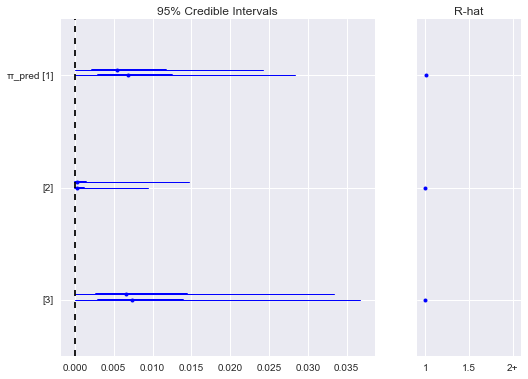

In [227]:
forestplot(pharm_trace, varnames=['π_pred']);

In [228]:
summary(pharm_trace, varnames=['π_pred']);


π_pred:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.009            0.013            0.001            [0.000, 0.027]
  0.004            0.023            0.001            [0.000, 0.012]
  0.013            0.025            0.001            [0.000, 0.035]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.003          0.006          0.012          0.035
  0.000          0.000          0.000          0.001          0.031
  0.000          0.003          0.007          0.014          0.051



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [229]:
summary(pharm_trace)


θ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.321           1.340            0.087            [-8.347, -3.179]
  -8.481           2.809            0.146            [-14.315, -3.166]
  -5.167           1.445            0.061            [-8.299, -2.654]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -8.806         -5.978         -5.110         -4.405         -3.305
  -14.902        -10.055        -8.295         -6.638         -3.454
  -8.731         -5.857         -4.948         -4.237         -2.919


σ_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.781            0.499            0.033            [-0.187, 1.686]

  Posterior quantiles:
  2.5            25           

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
